### monitor calibration and gamma correction
1. First step is to collect the luminance date with a luminance meter/photometer
2. Fit a gamma function

In [ ]:
% code to display stim and collect the luminance data with photometer (manual or USB) using PTB%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

AssertOpenGL;     %exit if obsolete version of PTB
Screen('Preference', 'SkipSyncTests', 1); 
%define configuration parameters
countdownDelay = 10;                %number of secs wait before measurements start
whichScreen=max(Screen('Screens')); %select secondary display (if available)
calSize=300;                        %size of square luminance target (pixels)
%build array of screen intensity values to be sampled [range:0-255]
indexValues=[7	15	22	29	36	44	51	58	66	73	80	87 ...
    95	102	109	117	124	131	138	146	153	160	168	175	... 
    182	189	197	204	211	219	226	233	240	248	255];
%prepare to take photometric measurements
try
   %open PTB full-screen window
   [window,mainRect]=Screen('OpenWindow',whichScreen);
   %generate linear gamma ramp for baseline calibration phase
   linearCLUT = repmat([0:255]'./255,1,3);
   %upload linear gamma function to video screen
   originalCLUT=Screen('LoadNormalizedGammaTable',window,linearCLUT);
   %set window background to GRAY
   Screen('FillRect',window,[128 128 128]);
   Screen('Flip',window);
   %remove mouse cursor from screen
   %HideCursor;
   %select large text font
   Screen('TextSize',window,36);
   %determine screen center-of-gravity coordinates
   xcenter = round((mainRect(3)-mainRect(1))/2);
   ycenter = round((mainRect(4)-mainRect(2))/2);
   %determine size of calibration luminance target
   targetRect=zeros(1,4);
   targetRect(1)=round(xcenter-(calSize/2));
   targetRect(2)=round(ycenter-(calSize/2));
   targetRect(3)=round(xcenter+(calSize/2));
   targetRect(4)=round(ycenter+(calSize/2));
   % 
   %begin countdown on PTB3 screen
   Screen('TextSize',window,50);
   for(i=countdownDelay:-1:0)
       textMsg = num2str(i);
       Screen('DrawText',window,textMsg,xcenter,ycenter,[0 0 0]);
       Screen('Flip',window);
       WaitSecs(1);
   end
   %GetChar;
   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
   % measure luminance for each value in indexValues[] %
   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
   xfeedback=mainRect(3)-100;
   yfeedback=mainRect(4)-80;
   for(i=1:length(indexValues))
       %update screen intensity level (2X to be sure)
       %display feedback re: current state at lower-right corner
       Screen('FillRect',window,indexValues(i),targetRect);
       Screen('DrawText',window,num2str(i),xfeedback,yfeedback,[0 0 0]);
       Screen('Flip',window);
       Screen('FillRect',window,indexValues(i),targetRect);
       Screen('DrawText',window,num2str(i),xfeedback,yfeedback,[0 0 0]);
       Screen('Flip',window);
       %
%        temp = ColorCal2('MeasureXYZ');
%        y(i)=temp.y;
%        x(i)=temp.x;
%        z(i)=temp.z;
       GetChar;
       %
   end
   
catch
    Screen('CloseAll');
    ShowCursor;
end

Now need to write the simple fitting code for a power function

In [1]:
%%file fitGam.m
function [sse,fit] = fitGam(par,x,y)
    
    % exponent parameter
    n = par(1);

    fit = x.^n;
    
    if nargin > 2
        sse = sum((y-fit).^2);
    else
        sse = NaN;
    

end


Created file '/Users/antonio/fitGam.m'.


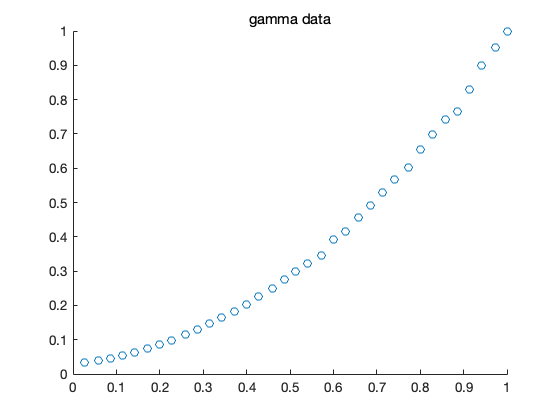

In [3]:
% same as index vaues
x = [7	15	22	29	36	44	51	58	66	73	80	87 ...
    95	102	109	 117	124	131	138	146	153	160	168	175	...
    182	189	197	204	211	219	226	233	240	248	255]'/255;
% now the luminance values gathered with photometer
y = [4.1,4.6,5.4,6.4,7.5,9.0,10.5,12.0,13.9,15.9,17.7,19.8,22.2,24.7,27.5,30.2,33.5,36.3,39.0,41.9,47.5, ...
             50.4,55.3,59.4,64.1,68.9,73.0,79.5,84.7,89.9,92.8,100.5,108.9,115.2,121.2]';
             
% normalize the data to max of 1
y = y./max(y);

% Plot the data
figure; clf; hold on
plot(x,y,'o'); title('gamma data');

Now we fit the data

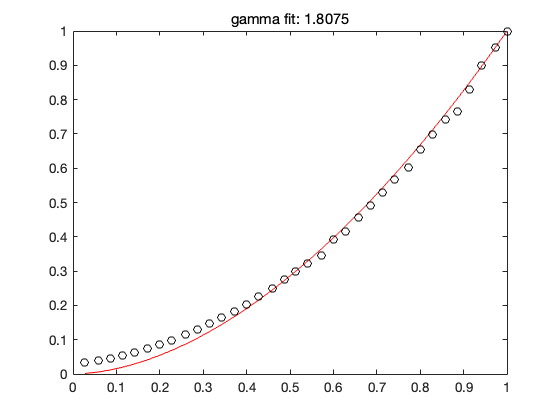

In [4]:
% now we fit a gamma power function to the data

% we'll be using fmincon to fit (function minimizer with constraints)
opt = optimoptions('fmincon','Algorithm','interior-point','Display','off');
% we have an idea of what the human gamma should be i.e. close to 2.2 
% this lets us control the parameter space
ub = [4]; % upper bound
lb = [1];  % lower bound 
x0 = [2];  % starting point  

% the function you want to fit
f = @(par)fitGam(par, x, y); 

% find the best fitting parameters using fmincon
[par,fval,exitflag,output,grad,hessian] = fmincon(f,x0,[],[],[],[],lb,ub,[],opt); 

%evaluate the function with the best fit parameters. 
[sse,fit] = fitGam(par, x, y);  

plot(x,fit,'-r'); hold on
plot(x, y, 'ok'); title(['gamma fit: ',num2str(par)]);

Last step is to invert the gamma function. The points should be on the line, except for the low values where the fit is ussually not so great.

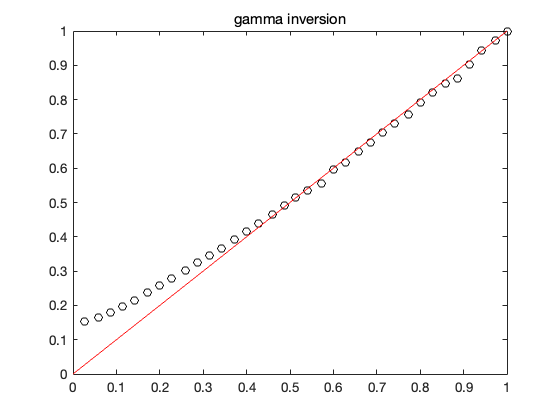

In [5]:
invert = max(x)*(y.^(1/par));

% plot the data
plot(x,invert,'ok');
line([0,1],[0,1],'color','r'); title('gamma inversion')

Now its time for the final step, which is generating the gamma table

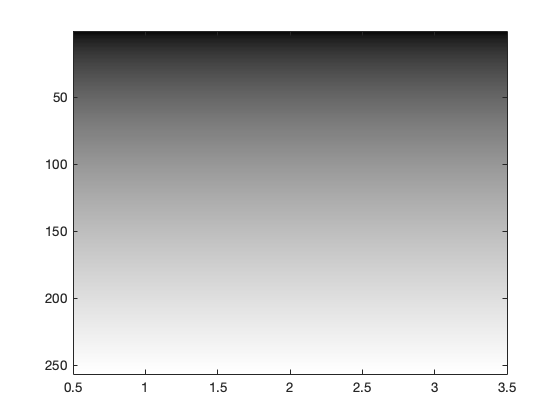

In [11]:
% sample full range
x_full=[0:1/255:1]; 

% new inversion
invert_full = max(x)*(x_full.^(1/par));

% normalize the inversion
invert_norm = invert_full./max(invert_full);

% in this case we only care about calibrating w/b not color so we just repmat for all three color values
GammaTable = repmat(invert_norm',1,3);

%plot the table for visualization because y not
imagesc(GammaTable); colormap gray

Sometimes a monitors luminance is offset by some value therefore in some cases it might benefit to add a second parameter to the fitting function to account for this. (i.e., $x^n+b$), where the $b$ is the new parameter